## Yunke Zhu and 1330327

**TODO**

## HW03 Code


You will complete the following notebook, as described in the PDF for Homework 03 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file and the two tree images (PDFs generated using `graphviz` within the code), to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2020/comp135).

### Import required libraries.

In [1]:
import os
import numpy as np
import pandas as pd

import warnings

import sklearn.linear_model
import sklearn.tree
import sklearn.metrics

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import graphviz

## Part One: Cancer-Risk Screening

### 1.1: Compute true/false positives/negatives.

Complete the following code.

In [147]:
def calc_TP_TN_FP_FN(ytrue_N, yhat_N):
    ''' Compute counts of four possible outcomes of a binary classifier for evaluation.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yhat_N : 1D array of floats
        Each entry represents a predicted binary value (either 0 or 1).
        One entry per example in current dataset.
        Needs to be same size as ytrue_N.

    Returns
    -------
    TP : float
        Number of true positives
    TN : float
        Number of true negatives
    FP : float
        Number of false positives
    FN : float
        Number of false negatives
    '''
    TP = 0.0
    TN = 0.0
    FP = 0.0
    FN = 0.0
    for i in range(len(ytrue_N)):
        real = ytrue_N[i]
        predict = yhat_N[i]
        if real == 1 and predict == 1:
            TP += 1
        if real == 0 and predict == 0:
            TN += 1
        if real == 1 and predict == 0:
            FN += 1
        if real == 0 and predict == 1:
            FP += 1
    return TP, TN, FP, FN

In [3]:
all0 = np.zeros(10)
all1 = np.ones(10)
calc_TP_TN_FP_FN(all0, all1)

(0.0, 0.0, 10.0, 0.0)

In [4]:
calc_TP_TN_FP_FN(all1, all0)

(0.0, 0.0, 0.0, 10.0)

In [5]:
calc_TP_TN_FP_FN(all1, all1)

(10.0, 0.0, 0.0, 0.0)

In [6]:
calc_TP_TN_FP_FN(all0, all0)

(0.0, 10.0, 0.0, 0.0)

### Supplied functions for later use

***Do not*** edit the following functions.  They are already complete, and will be used in your later code.

In [7]:
def calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute performance metrics for a given probabilistic classifier and threshold
    '''
    tp, tn, fp, fn = calc_TP_TN_FP_FN(ytrue_N, yproba1_N >= thresh)
    ## Compute ACC, TPR, TNR, etc.
    acc = (tp + tn) / float(tp + tn + fp + fn + 1e-10)
    tpr = tp / float(tp + fn + 1e-10)
    tnr = tn / float(fp + tn + 1e-10)
    ppv = tp / float(tp + fp + 1e-10)
    npv = tn / float(tn + fn + 1e-10)
    
    return acc, tpr, tnr, ppv, npv

def print_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Pretty print perf. metrics for a given probabilistic classifier and threshold
    '''
    acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
    
    ## Pretty print the results
    print("%.3f ACC" % acc)
    print("%.3f TPR" % tpr)
    print("%.3f TNR" % tnr)
    print("%.3f PPV" % ppv)
    print("%.3f NPV" % npv)

In [8]:
def calc_confusion_matrix_for_threshold(ytrue_N, yproba1_N, thresh):
    ''' Compute the confusion matrix for a given probabilistic classifier and threshold
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset
        Needs to be same size as ytrue_N
    thresh : float
        Scalar threshold for converting probabilities into hard decisions
        Calls an example "positive" if yproba1 >= thresh

    Returns
    -------
    cm_df : Pandas DataFrame
        Can be printed like print(cm_df) to easily display results
    '''
    cm = sklearn.metrics.confusion_matrix(ytrue_N, yproba1_N >= thresh)
    cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm_df.columns.name = 'Predicted'
    cm_df.index.name = 'True'
    return cm_df

In [9]:
def compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N, thresh_grid=None):
    ''' Compute common binary classifier performance metrics across many thresholds
    
    If no array of thresholds is provided, will use all 'unique' values
    in the yproba1_N array to define all possible thresholds with different performance.
    
    Args
    ----
    ytrue_N : 1D array of floats
        Each entry represents the binary value (0 or 1) of 'true' label of one example
        One entry per example in current dataset
    yproba1_N : 1D array of floats
        Each entry represents a probability (between 0 and 1) that correct label is positive (1)
        One entry per example in current dataset

    Returns
    -------
    thresh_grid : 1D array of floats
        One entry for each possible threshold
    perf_dict : dict, with key, value pairs:
        * 'acc' : 1D array of accuracy values (one per threshold)
        * 'ppv' : 1D array of positive predictive values (one per threshold)
        * 'npv' : 1D array of negative predictive values (one per threshold)
        * 'tpr' : 1D array of true positive rates (one per threshold)
        * 'tnr' : 1D array of true negative rates (one per threshold)
    '''
    if thresh_grid is None:
        bin_edges = np.linspace(0, 1.001, 21)
        thresh_grid = np.sort(np.hstack([bin_edges, np.unique(yproba1_N)]))
    tpr_grid = np.zeros_like(thresh_grid)
    tnr_grid = np.zeros_like(thresh_grid)
    ppv_grid = np.zeros_like(thresh_grid)
    npv_grid = np.zeros_like(thresh_grid)
    acc_grid = np.zeros_like(thresh_grid)
    for tt, thresh in enumerate(thresh_grid):
        # Apply specific threshold to convert probas into hard binary values (0 or 1)
        # Then count number of true positives, true negatives, etc.
        # Then compute metrics like accuracy and true positive rate
        acc, tpr, tnr, ppv, npv = calc_perf_metrics_for_threshold(ytrue_N, yproba1_N, thresh)
        acc_grid[tt] = acc
        tpr_grid[tt] = tpr
        tnr_grid[tt] = tnr
        ppv_grid[tt] = ppv
        npv_grid[tt] = npv
    return thresh_grid, dict(
        acc=acc_grid,
        tpr=tpr_grid,
        tnr=tnr_grid,
        ppv=ppv_grid,
        npv=npv_grid)

def make_plot_perf_vs_threshold(ytrue_N, yproba1_N, bin_edges=np.linspace(0, 1, 21)):
    ''' Make pretty plot of binary classifier performance as threshold increases
    
    Produces a plot with 3 rows:
    * top row: hist of predicted probabilities for negative examples (shaded red)
    * middle row: hist of predicted probabilities for positive examples (shaded blue)
    * bottom row: line plots of metrics that require hard decisions (ACC, TPR, TNR, etc.)
    '''
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))
    sns.distplot(
        yproba1_N[ytrue_N == 0],
        color='r', bins=bin_edges, kde=False, rug=True, ax=axes[0]);
    sns.distplot(
        yproba1_N[ytrue_N == 1],
        color='b', bins=bin_edges, kde=False, rug=True, ax=axes[1]);

    thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(ytrue_N, yproba1_N)
    axes[2].plot(thresh_grid, perf_grid['acc'], 'k-', label='accuracy')
    axes[2].plot(thresh_grid, perf_grid['tpr'], 'b-', label='TPR (recall/sensitivity)')
    axes[2].plot(thresh_grid, perf_grid['tnr'], 'g-', label='TNR (specificity)')
    axes[2].plot(thresh_grid, perf_grid['ppv'], 'c-', label='PPV (precision)')
    axes[2].plot(thresh_grid, perf_grid['npv'], 'm-', label='NPV')
    
    axes[2].legend()
    axes[2].set_ylim([0, 1])

### Load the dataset.

The following should ***not*** be modified.  After it runs, the various arrays it creates will contain the 2- or 3-feature input datasets.

In [79]:
# Load 3 feature version of x arrays
x_tr_M3 = np.loadtxt('./data_cancer/x_train.csv', delimiter=',', skiprows=1)
x_va_N3 = np.loadtxt('./data_cancer/x_valid.csv', delimiter=',', skiprows=1)
x_te_N3 = np.loadtxt('./data_cancer/x_test.csv', delimiter=',', skiprows=1)

# 2 feature version of x arrays
x_tr_M2 = x_tr_M3[:, :2].copy()
x_va_N2 = x_va_N3[:, :2].copy()
x_te_N2 = x_te_N3[:, :2].copy()

In [80]:
y_tr_M = np.loadtxt('./data_cancer/y_train.csv', delimiter=',', skiprows=1)
y_va_N = np.loadtxt('./data_cancer/y_valid.csv', delimiter=',', skiprows=1)
y_te_N = np.loadtxt('./data_cancer/y_test.csv', delimiter=',', skiprows=1)

### 1.2: Compute the fraction of patients with cancer.

Complete the following code.  Your solution needs to ***compute*** these values from the training, validation, and testing sets (i.e., don't simply hand-count and print the values).

In [12]:
def computeFrac(data):
    return sum(data)/len(data)

train_frac = computeFrac(y_tr_M)
valid_frac = computeFrac(y_va_N)
test_frac = computeFrac(y_te_N)

In [13]:
print("Fraction with cancer in TRAIN: %.3f" % train_frac) #TODO: modify what is printed here.
print("Fraction with cancer in VALID: %.3f" % valid_frac)
print("Fraction with cancer in TEST : %.3f" % test_frac)

Fraction with cancer in TRAIN: 0.141
Fraction with cancer in VALID: 0.139
Fraction with cancer in TEST : 0.139


### 1.3: The predict-0-always baseline

#### (a) Compute the accuracy of the always-0 classifier.

Complete the code to compute and print the accuracy of the always-0 classifier on validation and test outputs.

In [14]:
def computeAccuracy(data=None,baseline=None):
    TP, TN, FP, FN = calc_TP_TN_FP_FN(data,baseline)
    return float((TP + TN)/(TP+TN+FP+FN))

In [15]:
valid_all_zero = np.zeros(len(y_va_N))
valid_accuracy = computeAccuracy(y_va_N,valid_all_zero)

test_all_zero = np.zeros(len(y_te_N))
test_accuracy = computeAccuracy(y_te_N,test_all_zero)

In [16]:
print("Always-0: accuracy on VALID: %.3f" % valid_accuracy) # TODO edit values!
print("Always-0: accuracy on TEST : %.3f" % test_accuracy)

Always-0: accuracy on VALID: 0.861
Always-0: accuracy on TEST : 0.861


#### (b) Print a confusion matrix for the always-0 classifier.

Add code below to generate a confusion matrix for the always-0 classifier on the validation set.

In [17]:
# TODO call print(calc_confusion_matrix_for_threshold(...))
calc_confusion_matrix_for_threshold(y_va_N,valid_all_zero,1)
#print_perf_metrics_for_threshold(valid_all_zero,y_va_N,0)

Predicted,0,1
True,,
0,155,0
1,25,0


#### (c) Reflect on the accuracy of the always-0 classifier.

**Answer**: TODO

#### (d) Analyze the various costs of using the always-0 classifier.


**Answer**: TODO

### 1.4: Logistic Regression

#### (a) Create a set of `LogisticRegression` models.

Each model will use a different control parameter, `C`, and each will be fit to 2-feature data.  Probabilistic predictions will be made on both training set and validation set inputs, and logistic-loss for each will be recorded.

In [208]:
from sklearn.linear_model import LogisticRegression
tr_loss_list = list()
va_loss_list = list()

# TODO fit, predict_proba, and evaluate logistic loss    
# Record the best model here
def loss_detection(C,x_tr,y_tr,x_va,y_va):
    LRM = LogisticRegression(C=C,solver='liblinear').fit(x_tr, y_tr)
    pred_tr = LRM.predict_proba(x_tr)
    pred_va = LRM.predict_proba(x_va)
    return sklearn.metrics.log_loss(y_tr,pred_tr),sklearn.metrics.log_loss(y_va,pred_va) 

In [209]:
C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    tr_loss,va_loss = loss_detection(C,x_tr_M2,y_tr_M,x_va_N2,y_va_N)
    tr_loss_list.append(tr_loss)
    va_loss_list.append(va_loss)

#### Plot logistic loss (y-axis) vs. C (x-axis) on the training set and validation set.

The best values for `C` and the loss should be printed.

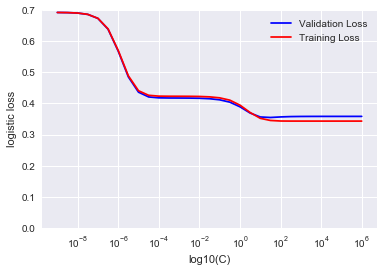

Best C-value for LR with 2-feature data: 31.623
Validation set log-loss at best C-value: 0.3549


In [210]:
# TODO make plot
plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('logistic loss')
plt.plot(C_grid,va_loss_list, color='blue',label = "Validation Loss")
plt.plot(C_grid,tr_loss_list, color='red',label = "Training Loss")
plt.ylim([0.0, 0.7]);

# TODO add legend
# plt.legend(...);
plt.legend()
plt.show()
print("Best C-value for LR with 2-feature data: %.3f" % C_grid[np.argmin(va_loss_list)]) # TODO
print("Validation set log-loss at best C-value: %.4f" % min(va_loss_list))

#### (b) Plot the performance of the predictions made by the best classifier from step (a) on the validation set.

In [211]:
best_C = C_grid[np.argmin(va_loss_list)]
LRM = LogisticRegression(C=best_C,solver='liblinear').fit(x_tr_M2, y_tr_M)
yproba = LRM.predict_proba(x_va_N2)[:,1]

In [214]:
yproba.shape

(180,)

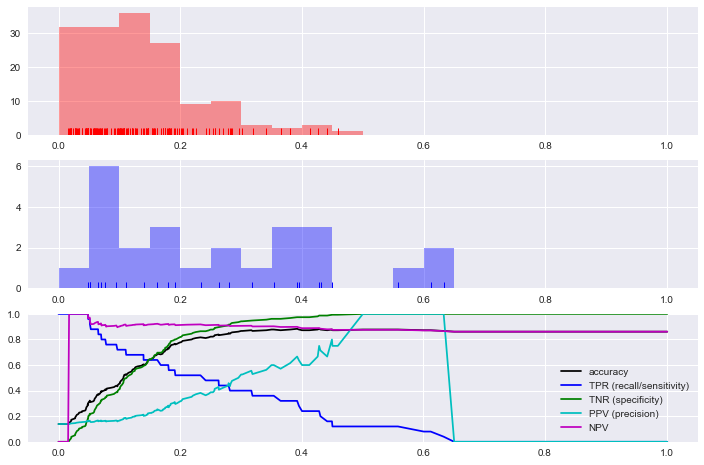

In [212]:
# TODO call make_plot_perf_vs_threshold(...)
make_plot_perf_vs_threshold(ytrue_N, yproba)

#### (c) Model fitting with 3-feature data

Repeat the model generation from **1.4 (a)**, using the full 3-feature data.

In [215]:
# TODO like 1.4 (a), but with 3 features
tr_loss_list = list()
va_loss_list = list()
C_grid = np.logspace(-9, 6, 31)
for C in C_grid:
    tr_loss,va_loss = loss_detection(C,x_tr_M3,y_tr_M,x_va_N3,y_va_N)
    tr_loss_list.append(tr_loss)
    va_loss_list.append(va_loss)

#### Plot logistic loss (y-axis) vs. C (x-axis) for the 3-feature classifiers on the training set and validation set.

Again, the best values for `C` and the loss should be printed.

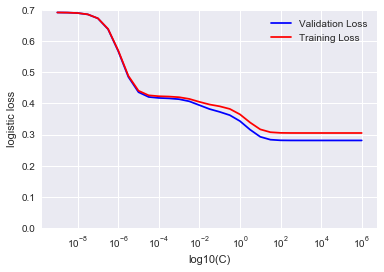

Best C-value for LR with 2-feature data: 1000000.000
Validation set log-loss at best C-value: 0.2810


In [216]:
# TODO make plot
plt.xscale('log')
plt.xlabel('log10(C)')
plt.ylabel('logistic loss')
plt.plot(C_grid,va_loss_list, color='blue',label = "Validation Loss")
plt.plot(C_grid,tr_loss_list, color='red',label = "Training Loss")
plt.ylim([0.0, 0.7]);

# TODO add legend
# plt.legend(...);
plt.legend()
plt.show()
print("Best C-value for LR with 2-feature data: %.3f" % C_grid[np.argmin(va_loss_list)]) # TODO
print("Validation set log-loss at best C-value: %.4f" % min(va_loss_list))

#### Plot the performance of the predictions made by the best 3-valued classifier on the validation set.

In [20]:
# TODO call make_plot_perf_vs_threshold(...)

### 1.5: ROC Curves

These curves allow us to compare model performance in terms of trade-offs between false positive and true positive results.

#### (a) Plot ROC curves on the validation set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

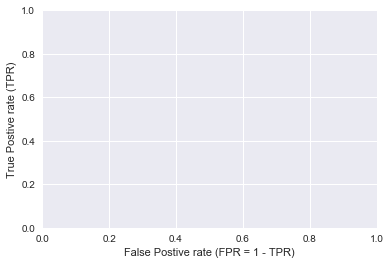

In [21]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

#### (b) Plot ROC curves on the test set.

There should be two curves in the plot, one for each of the best two classifiers from prior steps.

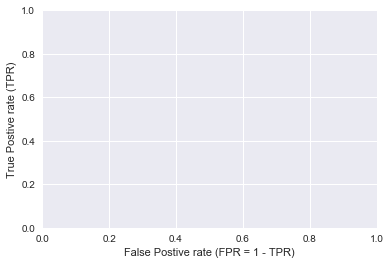

In [22]:
# TODO something like: fpr, tpr, thr = sklearn.metrics.roc_curve(...)

plt.ylim([0, 1]);
plt.xlabel("False Postive rate (FPR = 1 - TPR)");
plt.ylabel("True Postive rate (TPR)");

#### (c) Analyze the results shown in both the above plots, to compare classifier performance.

**Answer**: TODO

### 1.6: Selecting a decision threshold

#### (a) Using default 0.5 threshold. 

Generate a confusion matrix for the best 3-feature logistic model on the test set, using threshold 0.5.

In [23]:
best_thr = 0.5


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))

ON THE VALIDATION SET:
Chosen best thr = 0.5000

ON THE TEST SET:



#### (b) Pick a threshold to maximize TPR, while ensuring PPV >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [24]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)

# TODO Find threshold that makes TPR as large as possible, while satisfying PPV >= 0.98

print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % best_thr)
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))

ON THE VALIDATION SET:
Chosen best thr = 0.5000

ON THE TEST SET:



#### (c) Pick a threshold to maximize PPV, while ensuring TPR >= 0.98.

After finding the best threshold on the validation set, plot its confusion matrix and print its various performance metrics, for the test set.

In [25]:
# TODO thresh_grid, perf_grid = compute_perf_metrics_across_thresholds(...)

# TODO Find threshold that makes PPV as large as possible, while satisfying TPR >= 0.98


print("ON THE VALIDATION SET:")
print("Chosen best thr = %.4f" % 0.0) # TODO
print("")
print("ON THE TEST SET:")
# TODO: print(calc_confusion_matrix_for_threshold(...))
print("")
# TODO: print(print_perf_metrics_for_threshold(...))

ON THE VALIDATION SET:
Chosen best thr = 0.0000

ON THE TEST SET:



#### (d) Compare the confusion matrices from (a)–(c) to analyze the different thresholds.

**Answer**: TODO

#### (e) How many biopsies can be avoided using the best threshold for the classifier?

**Answer**: TODO

## Part Two: Decision Trees

You should start by computing the two heuristic values for the toy data described in the assignment handout. You should then load the two versions of the abalone data, compute the two heuristic values on features (for the simplified data), and then build decision trees for each set of data.

### 2.1 Compute both heuristics for toy data.

#### (a) Compute the counting-based heuristic, and order the features by it.

In [26]:
# TODO

#### (b) Compute the information-theoretic heuristic, and order the features by it.

In [27]:
# TODO

#### (c) Discussion of results.

*TODO*

### 2.2 Compute both heuristics for simplified abalone data.

#### (a) Compute the counting-based heuristic, and order the features by it.

In [28]:
# TODO

#### (b) Compute the information-theoretic heuristic, and order the features by it.

In [29]:
# TODO

### 2.3 Generate decision trees for full- and restricted-feature data

#### (a) Print accuracy values and generate tree images.

In [30]:
# TODO

#### (b) Discuss the results seen for the two trees

*TODO*